## <B> QF609 PROJECT - GROUP 3
#### 1. Zhao Geping
#### 2. Lu TingJia
#### 3. Xie Zuoyu
#### 4. Harshita Sachdev
#### 5. Zhang Yonghan 
#### 6. Horge Dragos
#### 7. Nguyen Thanh Binh

## GENERAL APPROACH

**With the assumption of `normal distribution`, the major step is to calculate the mean and variance of the whole portfolio in terms of dollar amount, then use these values to calculate VaR.**

**Risk factors of the portfolio**:
1. The changes in the SOFR rate of the swap tenors  
2. The changes in stock prices

---

- Calculating VaR is effectively finding a value at a certain percentile threshold.

---

- To calculate the mean changes in the portfolio value, we use the formula:

$$
\overline{\Delta P} = \vec{w}_i \cdot \vec{\mu}_i
$$

where $\vec{\mu}_i$ represents the mean changes of the risk factors in the portfolio, and $\vec{w}_i$ represents the weights (loading) of those factors.

---

To calculate the portfolio variance, we can use the following dot product:

$$
\vec{w}_i^\mathsf{T} \, \Sigma \, \vec{w}_i
$$

where $\Sigma \$ is the covariance of the daily changes of the risk factors in the portfolio.

---

To find $\vec{w}_i$, note that our portfolio has two major sub-portfolios: 
- The swap  
- The equity  

Each requires different methods:

- **For SOFR tenors**: we calculate `partial DV01`, which is the impact on the swap value of a 1bps increase in the SOFR of a tenor.  
- **For the equity**: their weights are simply their dollar positions, which is 1 million USD each in this project. 
  Note that the weight here is the dollar amount, not the percentage weight, 
  because we are evaluating the sensitivity of the whole portfolio in terms of dollar amount. 
  (Multiplying these \$1 million by their daily changes will provide the impacts of their daily changes on the whole portfolio.)

---

Following this, we can calculate the VaR models, either manually or by using packages.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt

from scipy.stats import norm

In [3]:
SOFR_df = pd.read_excel('hist_data.xlsm', sheet_name = 'SofrCurve', index_col = 'Tenor')
SOFR_df.columns = [col.strftime('%Y-%m-%d') if isinstance(col, dt.datetime) else col for col in SOFR_df.columns]
SOFR_df.head(3)

,T,2022-10-31,2022-11-01,2022-11-02,2022-11-03,2022-11-04,2022-11-07,2022-11-08,2022-11-09,2022-11-10,...,2023-10-17,2023-10-18,2023-10-19,2023-10-20,2023-10-23,2023-10-24,2023-10-25,2023-10-26,2023-10-27,2023-10-30
Tenor,,,,,,,,,,,,,,,,,,,,,
1D,0.002778,0.039191,0.039604,0.039948,0.040389,0.045965,0.040224,0.040339,0.040373,0.052075,...,0.052964,0.053038,0.053050,0.053072,0.053090,0.053105,0.052981,0.053047,0.052989,0.052967
1M,0.083333,0.038721,0.039023,0.039286,0.039585,0.042343,0.039258,0.039211,0.039193,0.043694,...,0.053114,0.053102,0.053086,0.053046,0.053077,0.053084,0.053057,0.053089,0.053040,0.053053
2M,0.166667,0.038670,0.038886,0.039100,0.039350,0.038795,0.039460,0.039420,0.039483,0.038786,...,0.053374,0.053284,0.053226,0.053128,0.053191,0.053202,0.053259,0.053218,0.053185,0.053265


## 1. DATA PREPARATION

### 1.1. DEFINE RE-USABLE FUNCTIONS

#### 1.1.1. Select the relevant data
* As the swap has annual payments and maturity of 10 years, we only need the SOFR corresponding to the tenors from 1Y to 10Y.

In [7]:
def Swap_data_prep(SOFR_df, Tenor_col = 'T', T_min = 1, T_max = 10): 
    """
    Some data pre processing so that the function is re-usable for other similar data and projects

    Inputs:
    - SOFR_df (DataFrame): raw data containing the tenors in years and the SOFR
    - T_min (float): the minimum tenor to be used, representing the payment structure, i.e. T = 1 for annual payment
    - T_max (float): represent the maturity of the swap
    
    Outputs:
    - Swap_df (DataFrame): a DataFrame with relevant SOFR for swap valuation
    """

    # Sorting the data by Tenors
    Swap_df = SOFR_df.copy()
    Swap_df[Tenor_col] = pd.to_numeric(Swap_df[Tenor_col], errors='coerce')
    Swap_df = Swap_df.sort_values(by = Tenor_col)

    # Slicing the relevant part of the data according to the maturity of the instrument
    Swap_df = Swap_df[Swap_df[Tenor_col].between(T_min, T_max)]

    return Swap_df

In [8]:
Swap_df = Swap_data_prep(SOFR_df)

Swap_df = Swap_df.apply(pd.to_numeric, errors = 'coerce')

In [9]:
# Swap_df.T.isna().sum()

In [10]:
# As there is only one NaN, we only do a simple linear interpolation here rather then def a function

NaN_idx = Swap_df.loc['9Y'][Swap_df.loc['9Y'].isna()].index # find the missing value

In [11]:
Swap_df.loc['9Y', NaN_idx] = (Swap_df.loc['8Y', NaN_idx] + Swap_df.loc['10Y', NaN_idx])/2

In [12]:
Swap_df.T.isna().sum()

Tenor
1Y     0
2Y     0
3Y     0
4Y     0
5Y     0
6Y     0
7Y     0
8Y     0
9Y     0
10Y    0
dtype: int64

#### 1.1.1. Swap Valuation

1. First we calculate the **Discount factors** assuming continuously compounding
$$
\
D(i, T) = e^{-r \times T}
\
$$

where \(r\) is the continuously compounded rate.

- E.g. For 2021-01-31, with $r = 0.0390231$, then
  $\
  D(\text{2021-01-31}, 1M) = e^{-0.0390231 \times 0.083333} \approx 0.996778.
  \$
- Thus on any given valuation day, we calculate the discount factor for each relevant tenor.

---

2. We can then calculate the **PV of the floating leg** of the swap by using a closed form approximation using Taylor series:
$$\
\text{PV}_{\text{float}, i} = 1 - D(i, T_{\max})
\
$$
(i.e. 1 minus the discount factor corresponding to the highest tenor)

- E.g. $$
\
1 - D(i, 40\text{Y})
\
$$

---

3. **Calculate the PV of the fixed leg**:  
It is essentially the product of the discount factors vector with the par swap rate (the strike).

For each given day \(i\):

$$
\text{PV}_{\text{fixed}, i} 
= \text{Par swap rate} \times \sum D\bigl(i, T\bigr)
$$

---

4. Calculate the **PV of the payer swap** by netting the PV of the two legs. It is effectively the NPV of the swap payer, so for each day, we take difference between the PV of the cash inflow (the floating leg) and the PV of the cash outflow (the fixed leg).
$$
\text{PV}_{\text{payer swap}, i} = \text{PV}_{\text{float}, i} - \text{PV}_{\text{fixed}, i}
\
$$

In [14]:
def Swap_Valuation_payer(Swap_df, Tenor_col = 'T', swap_rate = 0.042, notional = 1e8, 
                         valuation_date = '2022-10-31'):
    """
    Function to value the Swap payer for a given period. Parameters are set dynamically.

    Inputs:
    - Swap_df (DataFrame): DataFrame with relevant tenors (in years) and the SOFR to value the swap
    - swap_rate (float): the par swap rate / the strike
    - notional (float): the notional principal
    - valuation_date (str): Column corresponds to the valuation date, containing SOFR for tenors.

    Outputs:
    - Swap_calc (DF): DataFrame of detail calculation for double check
    - PV_Swap (float): value of the Swap payer
    """

    Swap_calc = Swap_df.copy()
    
    # Extracting the column name Zero rates
    val_date_idx = Swap_calc.columns.get_loc(valuation_date)
    zero_col = Swap_calc.columns[val_date_idx]

    # Sorting the data by Tenors
    Swap_calc[Tenor_col] = pd.to_numeric(Swap_calc[Tenor_col], errors='coerce')
    Swap_calc = Swap_calc.sort_values(by = Tenor_col)
    
    # Main calculation of swap values
    Swap_calc[zero_col] = pd.to_numeric(Swap_calc[zero_col], errors='coerce') # ensure the zero col are also numeric
    Swap_calc['Di'] = np.exp( -Swap_calc[Tenor_col] * Swap_calc[zero_col] )

    # Calculate the PV of the legs
    PV_float = 1 - Swap_calc['Di'].iloc[-1] # the iloc[-1] corresponds to the max tenor
    PV_fixed = Swap_calc['Di'].sum() * swap_rate

    # Calculate the PV of the Swap payers by netting the PV of the legs
    PV_Swap = (PV_float - PV_fixed) * notional

    Swap_calc = Swap_calc[[Tenor_col, zero_col, 'Di']]

    return Swap_calc, PV_Swap

In [242]:
valuation_date = Swap_df.columns[-1] # baseline day

Swap_calc, PV_Swap = Swap_Valuation_payer(Swap_df, valuation_date = valuation_date)

print(f'The value of the payer swap on {valuation_date} is ${PV_Swap:.2f}')

print('We can double check by having a look at the selected data and the calculated Discount factors:')
print(Swap_calc)

The value of the payer swap on 2023-10-30 is $2442902.00
We can double check by having a look at the selected data and the calculated Discount factors:
        T  2023-10-30        Di
1Y    1.0    0.052245  0.949097
2Y    2.0    0.047904  0.908638
3Y    3.0    0.045429  0.872591
4Y    4.0    0.044345  0.837462
5Y    5.0    0.043928  0.802808
6Y    6.0    0.043794  0.768923
7Y    7.0    0.043779  0.736051
8Y    8.0    0.043828  0.704247
9Y    9.0    0.043915  0.673524
10Y  10.0    0.044023  0.643887


In [16]:
# This function is not really needed for this project, but it can be helpful for our future career
# Following the swap valuation on a given day, we have a function to value the swap on all given days and plot the value overtime

def Swap_Valuation_mult(Swap_df, Tenor_col = 'T', swap_rate = 0.042, notional = 1e8, plot = False):
    """
    Value the swap on all given days and plot the value overtime; employing the predefined Swap_Valuation_payer for a given day.
    
    Inputs:
    - Swap_df (DataFrame): DataFrame with relevant tenors (in years) and the SOFR to value the swap
    - swap_rate (float): the par swap rate / the strike
    - notional (float): Notional principal of the swap
    
    Outputs:
    - PV_swap_df (DataFrame): A DataFrame with columns ['Date', 'PV_Swap'] for each valuation date.
    """
    
    # Assuming the first column is the tenor (in years) and the rest of the columns are valuation dates.
    # We can make this more adaptive when needed by generating a list of the SOFR dates
    valuation_dates = Swap_df.columns[1:]
    PV_swap_all = []
    
    # Loop through each valuation date, compute swap value, and append the result.
    # Employing our pre-defined function of swap payer valuation
    for date in valuation_dates:
        _, PV_Swap = Swap_Valuation_payer(Swap_df, Tenor_col = Tenor_col, swap_rate = swap_rate, 
                                          notional = notional, valuation_date = date)
        PV_swap_all.append(PV_Swap)
    
    # Create a DataFrame for all the dates and corresponding swap values
    Swap_calc_mult = pd.DataFrame({'Date': valuation_dates, 'V_Swap_payer': PV_swap_all})
    
    # Convert Date column to datetime
    Swap_calc_mult['Date'] = pd.to_datetime(Swap_calc_mult['Date'])

    if plot:
        plt.figure(figsize = (14,5))
        plt.plot(Swap_calc_mult['Date'], Swap_calc_mult['V_Swap_payer'])
        plt.xlabel('Valuation Date')
        plt.ylabel('Payer Swap Value')
        plt.title('Payer Swap Value Over Time', color = 'darkblue')
        plt.grid(True, alpha = 0.3)
    
    return Swap_calc_mult

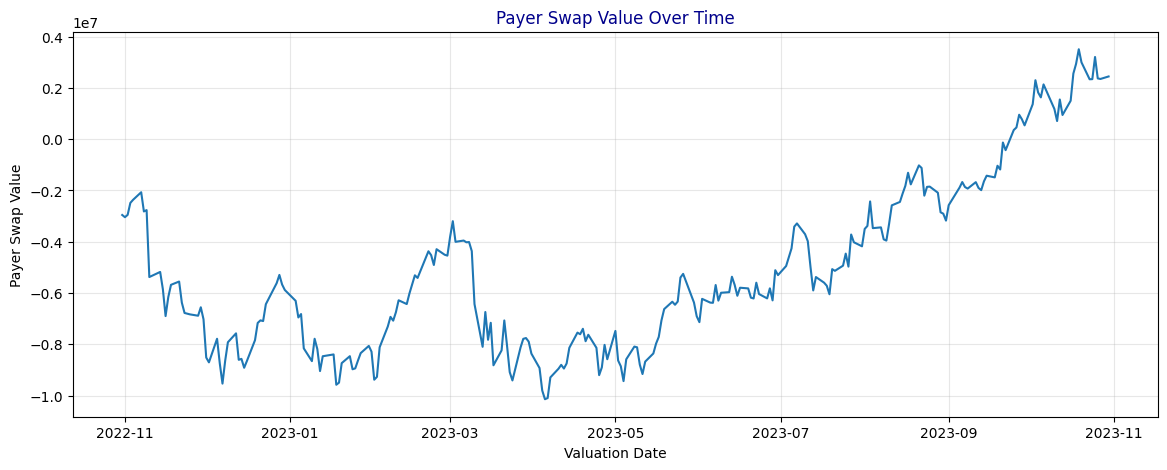

In [17]:
Swap_calc_mult = Swap_Valuation_mult(Swap_df, plot = True)

In [18]:
Swap_calc_mult

,Date,V_Swap_payer
0,2022-10-31,-2.958503e+06
1,2022-11-01,-3.044883e+06
2,2022-11-02,-2.954226e+06
3,2022-11-03,-2.487463e+06
4,2022-11-04,-2.367458e+06
...,...,...
246,2023-10-24,2.338622e+06
247,2023-10-25,3.202746e+06
248,2023-10-26,2.367237e+06
249,2023-10-27,2.345707e+06


#### 1.2. Partial DV01 (PV01)

* After calculating the swap value for each given day, we can perform sensitivity analysis.  
* In particular, we estimate the **DV01** for a 1-basis-point change in each tenor (partial DV01).  
* This is useful because it helps us understand which tenors have the greatest impact on the swap’s value if the yield curve shifts.

$$
\text{Partial DV01} 
= \frac{\text{PV}_{\text{new swap payer}} - \text{PV}_{\text{baseline swap payer}}}{0.0001}
$$

**Steps**:
1. Increase the SOFR rate of a tenor for all given days by 1 bps (those of the other tenors remain unchanged).  
2. Recalculate $\text{PV}_{\text{swap payer}}$ to get $\text{PV}_{\text{new swap payer}}$.  
3. Calculate $\text{PV01}$ using the formula above.
4. Append the results for all tenors to get a vector of PV01 values. These represent the sensitivities (or weightings) for each risk factor, which can then be used for portfolio-level evaluations.

In [20]:
def Swap_PV01_calc(Swap_df, Tenor_col = 'T', swap_rate = 0.042, notional = 1e8, 
                   valuation_date = '2023-10-30'):
    """
    Calculate Partial DV01 (PV01) for each tenor by bumping the zero rate for that tenor by 1 bp.
    
    Inputs:
    - Swap_df (DataFrame): DataFrame with tenors and SOFR data.
    - swap_rate (float): the par swap rate / the strike.
    - notional (float): the notional principal.
    - valuation_date (str): the column corresponding to the valuation date containing SOFR.
    
    Outputs:
    - PV01_df (DataFrame): A DataFrame with columns ['T', 'PV01'] containing the PV01 for each tenor.
    """

    calc_df = Swap_df.copy()
    
    # Calculate the baseline swap payer value using Swap_Valuation_payer
    _, PV_Swap_baseline = Swap_Valuation_payer(calc_df, Tenor_col = Tenor_col, swap_rate = swap_rate, 
                                               notional = notional, valuation_date = valuation_date)
    
    # Loop over each row in the DataFrame (each row corresponds to one tenor) to calculate PV01
    PV01_list = []
    tenors_list = []
    
    for idx, row in calc_df.iterrows():
        df_bumped = calc_df.copy()
        df_bumped.loc[idx, valuation_date] = df_bumped.loc[idx, valuation_date] + 1e-4 # bump 1 bps = 0.0001
        
        # Recalculate the swap value with the bumped rate
        _, PV_Swap_bumped = Swap_Valuation_payer(df_bumped, Tenor_col = Tenor_col, swap_rate = swap_rate, 
                                                 notional = notional, valuation_date = valuation_date)
        
        # Calculate Partial DV01
        PV01 = (PV_Swap_bumped - PV_Swap_baseline) / 1e-4
        PV01_list.append(PV01)
        tenors_list.append(row[Tenor_col])
    
    # Create a DataFrame
    PV01_df = pd.DataFrame({'T': tenors_list, 'PV01': PV01_list})
    
    return PV01_df

In [21]:
PV01_df = Swap_PV01_calc(Swap_df, valuation_date = '2023-10-30')
PV01_df

,T,PV01
0,1.0,3.986007e+06
1,2.0,7.631797e+06
2,3.0,1.099300e+07
3,4.0,1.406655e+07
4,5.0,1.685475e+07
5,6.0,1.937106e+07
6,7.0,2.163234e+07
7,8.0,2.365323e+07
8,9.0,2.544777e+07
9,10.0,6.705953e+08


### 1.2. EQUITY PREPARATION

To evaluate the sensitivity of the portfolio to the daily changes of the stocks, we calculate 
the mean daily return of each stock over the period, then multiply by the value of the positions.

$$
\Delta \text{Equity} 
= \sum_{i=1}^{4} \bigl(R_i \times w_i\bigr)
$$

where $R_i$ is the daily mean return of stock $i$, and $w_i$ is \$1 million 
for each stock in this project.

In [23]:
AAPL_df = pd.read_excel('hist_data.xlsm', sheet_name = 'AAPL', index_col = 'Date')
AAPL_df.columns = ['AAPL']

MSFT_df = pd.read_excel('hist_data.xlsm', sheet_name = 'MSFT', index_col = 'Date')
MSFT_df.columns = ['MSFT']

F_df = pd.read_excel('hist_data.xlsm', sheet_name = 'F', index_col = 'Date')
F_df.columns = ['F']

BAC_df = pd.read_excel('hist_data.xlsm', sheet_name = 'BAC', index_col = 'Date')
BAC_df.columns = ['BAC']

stock_prices = pd.concat([AAPL_df, MSFT_df, F_df, BAC_df], axis = 1)
stock_returns = stock_prices.pct_change().dropna()
stock_returns

,AAPL,MSFT,F,BAC
Date,,,,
2022-11-01,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.003902,0.029270,0.014064,0.005980
...,...,...,...,...
2023-10-24,0.002543,0.003674,-0.007840,-0.003911
2023-10-25,-0.013492,0.030678,0.013169,0.003141
2023-10-26,-0.024606,-0.037514,-0.016464,0.022309


### 1.3. PORTFOLIO PREPARATION

### 1.3.1. Weight Vector

In [26]:
PV01_weights = PV01_df['PV01'].to_numpy()

stock_weights = np.full(4, 1e6)

risk_factor_weights = np.concatenate((PV01_weights, stock_weights))
risk_factor_weights
# OK so this is the WEIGHT VECTOR of the risk factors for later use

array([3.98600677e+06, 7.63179678e+06, 1.09930011e+07, 1.40665536e+07,
       1.68547510e+07, 1.93710561e+07, 2.16323359e+07, 2.36532276e+07,
       2.54477691e+07, 6.70595263e+08, 1.00000000e+06, 1.00000000e+06,
       1.00000000e+06, 1.00000000e+06])

### 1.3.2. Portfolio mean and variance

In [28]:
SOFR_d = Swap_df.T.iloc[1:].diff().dropna()
SOFR_d.columns.name = None
SOFR_d.index.name = 'Date'
SOFR_d.index = pd.to_datetime(SOFR_d.index)

In [29]:
# SOFR_d.isna().sum()
# stock_returns.isna().sum()

In [30]:
# SOFR_d.index.difference(stock_returns.index)
# check mis-aligned index and we find that the SOFR have 2 extra daily data

In [31]:
# The data table of the changes in the risk factors
P_rates_changes = pd.concat([SOFR_d, stock_returns], axis = 1)
P_rates_changes.head()

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,AAPL,MSFT,F,BAC
Date,,,,,,,,,,,,,,
2022-11-01,0.000521,0.000439,0.000342,0.000296,0.000225,0.000124,0.000029,-0.000043,-0.000097,-0.000144,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,0.000234,0.000474,0.000404,0.000254,0.000153,0.000118,0.000109,0.000099,0.000090,0.000091,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,0.000690,0.001098,0.001085,0.000957,0.000832,0.000761,0.000704,0.000624,0.000545,0.000495,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.000394,-0.000497,-0.000448,-0.000322,-0.000204,-0.000116,-0.000038,0.000045,0.000126,0.000192,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.000429,0.000536,0.000499,0.000413,0.000332,0.000313,0.000328,0.000342,0.000345,0.000339,0.003902,0.029270,0.014064,0.005980


In [32]:
P_rates_changes.isna().sum()

P_rates_changes = P_rates_changes.dropna()
# remove NaN due to extra data in the SOFR, which is considered less biased then filling 

In [33]:
# Mean rate changes
P_rates_changes_mean = P_rates_changes.mean()
P_rates_changes_mean

1Y      0.000018
2Y      0.000007
3Y      0.000007
4Y      0.000012
5Y      0.000015
6Y      0.000017
7Y      0.000020
8Y      0.000021
9Y      0.000023
10Y     0.000024
AAPL    0.000461
MSFT    0.001606
F      -0.000738
BAC    -0.001181
dtype: float64

In [34]:
# Mean daily change of the portfolio value
P_mean_changes = risk_factor_weights @ P_rates_changes_mean
P_mean_changes

18485.85162743529

In [35]:
# Covar matrix
P_covar = P_rates_changes.cov()

In [36]:
# P_covar

In [37]:
# risk_factor_weights.shape
# P_covar.shape

In [38]:
# Mean daily volatility of the portfolio value
P_var = risk_factor_weights.T @ P_covar @ risk_factor_weights
P_sd = np.sqrt(P_var)
P_sd

580820.6277486501

## 2. PARAMETRIC VAR

With the assumption of `normal distribution`, we can find the 95th percentile by using: 

$$
\text{Parametric VaR}_{95} = \overline{\Delta P} \;+\; z \times \sigma_P
$$

where 
- $\overline{\Delta P}$ is the expected change in the portfolio, 
- $z$ is the z-score corresponding to the 95% confidence level (approximately 1.645), 
- $ \sigma_P$ is the standard deviation of the portfolio's returns.

In [41]:
# Confidence level and corresponding Z-score
confidence_level = 0.95
z = norm.ppf(1 - confidence_level)
z

-1.644853626951472

In [42]:
# Calculate Parametric VaR using the provided formula
VaR_para = abs(P_mean_changes + z * P_sd)
print(f"Parametric VaR at {confidence_level * 100}% confidence level: ${VaR_para:,.2f}")

Parametric VaR at 95.0% confidence level: $936,879.06


## 3. HISTORICAL VAR

**Risk-based approach**  
- Essentially, we take the direct product of the weights with the daily changes and then determine the 95th percentile.  
- This assumes a linear relationship between changes in risk factors and changes in portfolio value.

---

**Full revaluation approach**  
- Instead of using a linear approximation for sensitivity and VaR, we fully re-calculate the swap position and the equity position. We then sum these values to get the total portfolio value.

- The `historical VaR` relies on the assumption that history repeats. Hence, each of the historical data point is treated as a scenario under historical VaR analysis.

- We generate a new set of SOFR values by adding the historical daily changes to the current SOFR (last day of the given period).

- Using these new SOFR values, we calculate the new swap values.

- For the equity position, given the intial value for each stock is $1M, we can calculate the new value as 1M x (1 + daily return).

- Taking the sum of the new swaps and equity values gives us a vector of the new portfolio values under scenarios.

- Subtract the new portfolio values from the baseline value gives us a vector of portfolio changes under scenarios. Then we find the 95th percentile of these values.

In [44]:
# Identify NaN values in P_rates_changes
nan_counts = P_rates_changes.isna().sum()
print("NaN counts per column in P_rates_changes:\n", nan_counts)

NaN counts per column in P_rates_changes:
 1Y      0
2Y      0
3Y      0
4Y      0
5Y      0
6Y      0
7Y      0
8Y      0
9Y      0
10Y     0
AAPL    0
MSFT    0
F       0
BAC     0
dtype: int64


### 3.1. Risk-based

$$
\Delta P = w^T \cdot \Delta X
$$

$$
\text{VaR}_{\alpha} = -\text{Percentile}_{1-\alpha}(\Delta P)
$$

In [47]:
# Compute portfolio value daily changes using dot product
portfolio_value_changes_risk_based = P_rates_changes @ risk_factor_weights
portfolio_value_changes_risk_based # should give an output vector of daily changes

Date
2022-11-01   -107647.228769
2022-11-02    -15354.941103
2022-11-03    382077.795049
2022-11-04    187122.032162
2022-11-07    333486.623931
                  ...      
2023-10-24      -999.474390
2023-10-25    900308.581935
2023-10-26   -894592.280498
2023-10-27   -166544.013928
2023-10-30    133727.175245
Length: 248, dtype: float64

In [48]:
# Compute Historical VaR as the 5th percentile (negative of 95% percentile)
historical_var_risk_based = -np.percentile(portfolio_value_changes_risk_based, 5)
historical_var_risk_based

980180.0116969945

### 3.2. Full revaluation

$$
P_{\text{new}} = \text{New Swap Value} + \text{New Equity Value}
$$

$$
\Delta P_{\text{full}} = P_{\text{new}} - P_{\text{baseline}}
$$

$$
\text{VaR}_{\alpha} = -\text{Percentile}_{1-\alpha}(\Delta P_{\text{full}})
$$

In [51]:
initial_SOFR = Swap_df.T.iloc[-1]
initial_stock = stock_prices.iloc[-1]

In [52]:
# 1: Compute Baseline Portfolio Value

# Baseline Payer Swap Value
_, baseline_swap_value = Swap_Valuation_payer(Swap_df, valuation_date='2023-10-30') # swap

# Assume $1M in each stock, total equity position = $4M
baseline_equity_value = 4e6

# Compute total baseline portfolio value
baseline_portfolio_value = baseline_swap_value + baseline_equity_value

In [53]:
baseline_portfolio_value

6442901.999846325

In [54]:
# 2: Revaluate swap with historical changes as scenarios
new_swap_values = []

# Let n_swap be the number of columns corresponding to swap (tenor) changes.
n_tenors = len(PV01_weights)

# Loop over each historical day (each row in P_rates_changes)
for date, row in P_rates_changes.iterrows():

    # Extract the one-day change for swaps (as a Series)
    swap_daily_change = row.iloc[:n_tenors]

    # Compute the new SOFR rates: baseline + one-day change
    SOFR_revalued = initial_SOFR + swap_daily_change 

    # Copy the original swap DataFrame and update the rate columns
    new_swap_df = Swap_df.copy()
    new_swap_df.iloc[:, 1:] = SOFR_revalued.values.reshape(-1, 1)

    # Revalue the swap portfolio using the updated rates
    _, swap_value = Swap_Valuation_payer(new_swap_df, valuation_date='2023-10-30')
    new_swap_values.append(swap_value)

# new_swap_values

In [55]:
# 3: Revaluate the Equity position with historical changes as scenarios
new_equity_values = []

for date, row in P_rates_changes.iterrows():
    
    daily_stock_return = row.iloc[n_tenors:] # Extract the one-day stock returns (simple returns)
    
    # For each stock, the new value is: baseline (1e6) * (1 + daily_return)
    new_stock_values = 1e6 * (1 + daily_stock_return)
    
    # Sum across all stocks to get the total new equity value for that day
    new_equity_value = new_stock_values.sum()
    new_equity_values.append(new_equity_value)

In [56]:
# 4: Compute New Portfolio Values (Swap + Equity) for each scenario (one-day revaluation)
new_portfolio_values = np.array(new_swap_values) + np.array(new_equity_values)

# this generate a vector of new portfolio values over time

In [57]:
# 5: Compute one-day PnL for each scenario:
# Difference between the revalued portfolio and the baseline portfolio value

portfolio_value_changes_full_reval = new_portfolio_values - baseline_portfolio_value

In [58]:
# 6: Compute Historical VaR (Full Revaluation) as the 5th percentile

historical_var_full_reval = -np.percentile(portfolio_value_changes_full_reval, 5)

In [59]:
print("1. Historical VaR Risk-Based Approach")
print(f"VaR (95% Confidence Level): ${historical_var_risk_based:,.2f}\n")
print("2. Historical VaR Full Revaluation Approach")
print(f"VaR (95% Confidence Level): ${historical_var_full_reval:,.2f}\n")

1. Historical VaR Risk-Based Approach
VaR (95% Confidence Level): $980,180.01

2. Historical VaR Full Revaluation Approach
VaR (95% Confidence Level): $986,112.37



## 4. MONTE CARLO VAR

* The approach for risk-based and revaluation approach is similar to `historical VaR`. The only difference is that we now use the simulated set instead of the historical set

In [61]:
#1 Setting seed
np.random.seed(42)

#2 Setting parameters
num_simulations = 10000
confidence_level = 0.95

#3 inputs from data
mu = P_rates_changes.mean().values #mean change in each risk factor
cov_matrix = P_rates_changes.cov().values #covriances of the risk factor
weights = risk_factor_weights #portfolio's sensitivity to each risk factor
baseline_value = baseline_portfolio_value #current total value of our portfolio as starting reference

#4 generating random shocks
simulated_risk_changes = np.random.multivariate_normal(mu, cov_matrix, num_simulations)

### 4.1. Risk-based

In [63]:
# Calculating portfolio's profit/loss under each simulated scenario using linear approximation
portfolio_changes_risk_based = simulated_risk_changes @ weights

#5th percentile of the profit/loss distribution is VaR
mc_var_risk_based = -np.percentile(portfolio_changes_risk_based, (1 - confidence_level) * 100)

print(f"Monte Carlo Risk-Based VaR (95% confidence): ${mc_var_risk_based:,.2f}")

Monte Carlo Risk-Based VaR (95% confidence): $918,459.82


### 4.2. Full revaluation

In [65]:
# Latest market rates for SOFR 
# and most recent equity price as the starting point
latest_SOFR_rates = Swap_df.iloc[:, -1].copy()
latest_equity_prices = stock_prices.iloc[-1].copy()
# print(latest_SOFR_rates)

new_portfolio_values = []

#Run full revaluation loop; each loop is for one simulation
for i in range(num_simulations):
    simulated_factors = simulated_risk_changes[i]

    # Apply first 10 shocks to SOFR rates
    sofr_shocks = simulated_factors[:10]
    new_SOFR_rates = latest_SOFR_rates + sofr_shocks

    # Update Swap DataFrame safely 
    new_Swap_df = Swap_df.copy()
    new_Swap_df.loc[new_SOFR_rates.index, Swap_df.columns[-1]] = new_SOFR_rates.values

    # Revalue the interest rate swap using the simulated SOFR
    _, new_swap_value = Swap_Valuation_payer(new_Swap_df, valuation_date=Swap_df.columns[-1])

    # Apply last 4 shocks to equities as returns
    equity_returns = simulated_factors[10:]
    new_equity_prices = 1e6 * (1 + equity_returns)
    # New value of equity portfolio
    new_equity_value = new_equity_prices.sum()

    # Total portfolio value
    total_portfolio_value = new_swap_value + new_equity_value
    new_portfolio_values.append(total_portfolio_value)

# computing the portfolio P&L for each simulation/scenario 
#by subtracting the baseline value
portfolio_changes_full_reval = np.array(new_portfolio_values) - baseline_value

# 5th percentile of the PnL distribution is VaR
mc_var_full_reval = abs(-np.percentile(portfolio_changes_full_reval, (1 - confidence_level) * 100))

print(f"Monte Carlo Full Revaluation VaR (95% confidence): ${mc_var_full_reval:,.2f}")

Monte Carlo Full Revaluation VaR (95% confidence): $923,297.71


## 5. COMPARISONS OF APPROACHES

In [67]:
VaR_df_all = pd.DataFrame({
    "Estimates": [
        VaR_para, 
        historical_var_risk_based, 
        historical_var_full_reval, 
        mc_var_risk_based, 
        mc_var_full_reval
    ]
}, index=[
    "Parametric VaR", 
    "Historical VaR_Risk based", 
    "Historical VaR_Full reval.",
    "Monte Carlo VaR_Risk based",
    "Monte Carlo VaR_Full reval."
])

VaR_df_all = VaR_df_all.round(2)
VaR_df_all['Estimates'] = VaR_df_all['Estimates'].apply(lambda x: f"{x:,.2f}")

VaR_df_all

,Estimates
Parametric VaR,"936,879.06"
Historical VaR_Risk based,"980,180.01"
Historical VaR_Full reval.,"986,112.37"
Monte Carlo VaR_Risk based,"918,459.82"
Monte Carlo VaR_Full reval.,"923,297.71"


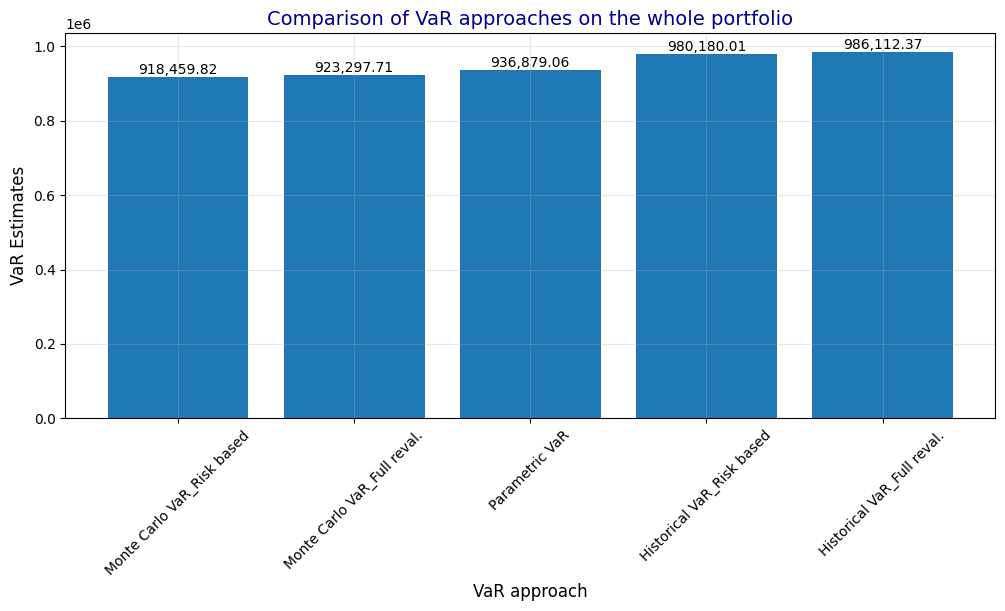

In [68]:
VaR_df_all['Estimates_numeric'] = VaR_df_all['Estimates'].str.replace(',', '').astype(float)

VaR_df_all_2 = VaR_df_all.sort_values(by = 'Estimates_numeric')

plt.figure(figsize=(12, 5))
bars = plt.bar(range(len(VaR_df_all_2)), VaR_df_all_2.Estimates_numeric)
plt.grid(alpha = 0.3)
plt.title('Comparison of VaR approaches on the whole portfolio', fontsize = 14, color = 'darkblue')
plt.xlabel('VaR approach', fontsize=12)
plt.xticks(range(len(VaR_df_all_2)), VaR_df_all_2.index, rotation=45)
plt.ylabel('VaR Estimates', fontsize = 12)

# Annotate each bar with the formatted value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height,                           
        f'{height:,.2f}',
        ha = 'center', 
        va = 'bottom')

#### <b>Brief discussion:</b>

1.&nbsp;&nbsp;<b style="color: blue;">Parametric VaR</b>:  
- Uses analytical formulas and the variance-covariance matrix assuming normally distributed returns.

**Advantages:**
- Fast as it relies on analytical formulas.
- Easy implementation.

**Limitations:**
- The assumption about normally distributed returns is not always true in financial markets
- This methodology may underestimate extreme risk in volatile/crisis periods as the return distributions have fatter tails in reality. 

  
<br>

2.&nbsp;&nbsp;<b style="color: green;">Monte Carlo VaR</b>:  
- Yield least conservative results ($918,459.82$ and $923,297.71$).
- Simulates a large number of potential outcomes for portfolio returns by sampling from a statistical model.  

**Advantages:**
 - This is a flexible model as it can model non-normal distributions and fat tails.
 - It can incorporate stress testing by changing the distribution of returns.

**Limitations:**
- It is computationally intensive as it requires more processing for bigger portfolios.
- The accuracy of results depends on the assume distribution and correlations. 

<br>

3.&nbsp;&nbsp;<b style="color: red;">Historical VaR</b>:  
- Yield most conservative results (highest VaRs of $980,180.01$ and $986,112.37$).
- Uses actual historical returns to form an empirical loss distribution.  


**Advantages:**
- Since it uses real market data, there is no assumptions about the distribution of returns required.
- It is also able to capture extreme risks if the historical data has data on crisis events.
- It is easy to implement.

**Limitations:**
- It is backward looking as it assumes history repeats itself.
- The accuracy of the results depends on the quality of the data.

## 6. FURTHER IMPROVEMENTS

### 6.1. Check Normality for the validity of Parametric VaR

* Can use some Normality test such as JB, or calculate the skewness and kurtosis of the portfolio data.
* So we can confirm the validity of Parametetric VaR using the assumption of normal distribution. Otherwise, we need to do adjustments.

### 6.2. Combine functions of VaRs

* In this project, we allocate the tasks to the members.
* In practice, we can define a general function to estimate VaR with dynamic parameters of the VaR types, so that the function can provides all the VaR estimate simultaneously given the input data set.